In [6]:
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv
import numpy as np
import skcuda.linalg as culinalg
import skcuda.misc as cumisc
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

culinalg.init()
m =18576
n= 2064
housing = pd.read_csv('cal_housing_clean.csv');
housing = shuffle(housing)

X = housing[['housingMedianAge','totalRooms','totalBedrooms','population','households','medianIncome']]
Y = housing[['medianHouseValue']]
X = X.values
Y = Y.values

X=MinMaxScaler().fit_transform(X)
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=101)
X_train = np.ascontiguousarray(X_train.astype(np.float64).T)
Y_train = Y_train.astype(np.float64)
Y_train = np.reshape(Y_train,(1,m))
X_test = np.ascontiguousarray(X_test.astype(np.float64).T)
Y_test = Y_test.astype(np.float64)
Y_test = np.reshape(Y_test,(1,n))
#X_train = np.random.randn(6,m).astype(np.float64)
GX_train = gpuarray.to_gpu(X_train)
GY_train = gpuarray.to_gpu(Y_train)
GX_test = gpuarray.to_gpu(X_test)
GY_test = gpuarray.to_gpu(Y_test)
W = np.zeros((1,6)).astype(np.float64);
alpha = 0.1
WG = gpuarray.to_gpu(W);
b =np.zeros((1,1));
Gb = gpuarray.to_gpu(b)
costs = []
for i in range(10000):
    ycap = culinalg.dot(WG,GX_train)
    ycap = cumisc.add(ycap,Gb);
    grad = np.array([0,0,0,0,0,0])
    ed = (ycap-GY_train)
    cost = ed*ed
    cost = cumisc.sum(cost,axis=1)
    cost = cost.get()
    costs.append(cost[0])
    b = alpha*cumisc.sum(ed)/m
    grad = cumisc.multiply(ed,GX_train)
    grad = cumisc.sum(grad,axis=1)
    grad = alpha*grad/m
    grad = grad.reshape(1,6)
    WG = WG-grad
print(WG)


[[  92661.85150997  -94310.68512048  173405.88163142 -185817.28566056
   152367.07069376  620131.61627033]]


In [9]:
def lr_predict(X_test,Y_test,W,b,n):
    ycap = culinalg.dot(WG,X_test)
    ycap = cumisc.add(ycap,Gb)
    ed = (ycap-Y_test)
    cost = ed*ed    
    error = cumisc.sum(cost,axis=1)/n
    return ycap,error    
    
    
    

[  5.89565778e+09]
[  58500.  154600.  260000. ...,  184100.  162500.  107900.]
(2064,)


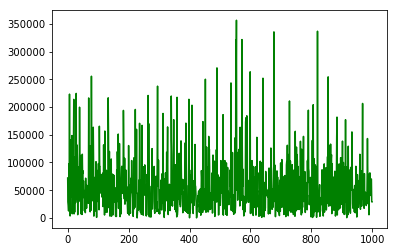

In [11]:
%matplotlib inline
#plt.gca().set_color_cycle(['red', 'green'])

ycap_test,error =lr_predict(GX_test,GY_test,WG,b,n)
print(error)
print(Y_test)
ycap_test=ycap_test.get()
Y_test = np.squeeze(Y_test)
ycap_test = np.squeeze(ycap_test)
# diff = np.mod(ycap_test-Y_test)
# print(diff)

print(Y_test.shape)
#ycap_test = np.squeeze(ycap_test[0:1000])#
#plt.plot(Y_test[0:100],)
#plt.plot(ycap_test[0:100],color='r')
plt.plot(np.abs(ycap_test-Y_test)[0:1000],color='g')

plt.show()

<class 'numpy.ndarray'>
(10000,)


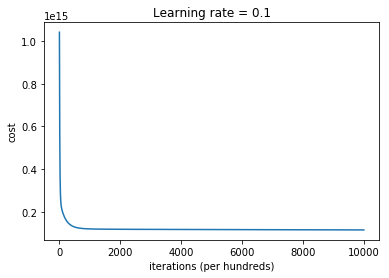

In [12]:
%matplotlib inline
# Plot learning curve (with costs)
costs = np.squeeze(costs)
print(type(costs))
print(costs.shape)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.1")
plt.show()